🔷 Resumen estadístico de las cantidades:
count    9.360000e+02
mean     1.393616e+05
std      3.026886e+05
min      0.000000e+00
25%      8.733802e+03
50%      3.072600e+04
75%      1.223761e+05
max      3.001498e+06
Name: Cantidades, dtype: float64

🔷 Valores únicos por columna:
Trimestre: 4 categorías
Provincia: 9 categorías
Puerto: 82 categorías
Rubro: 20 categorías
Tipo de Operación: 6 categorías
Unidad: 2 categorías

🔷 Puertos con mayor volumen operado:
Puerto
Bahía Blanca    12255816.00
Terminal 6       9108980.00
Renova           8491667.67
Rosales          7260888.53
Quequén          6568072.00
Name: Cantidades, dtype: float64

🔷 Rubros más frecuentes:
Rubro
Combustibles    223
Granos          127
Subproductos     92
Químicos         80
Aceites          69
Name: count, dtype: int64

🔷 Tipo de operación más comunes:
Tipo de Operación
Exportación                      390
Importación                      195
Cabotaje Entrado                 165
Cabotaje Salido                  109

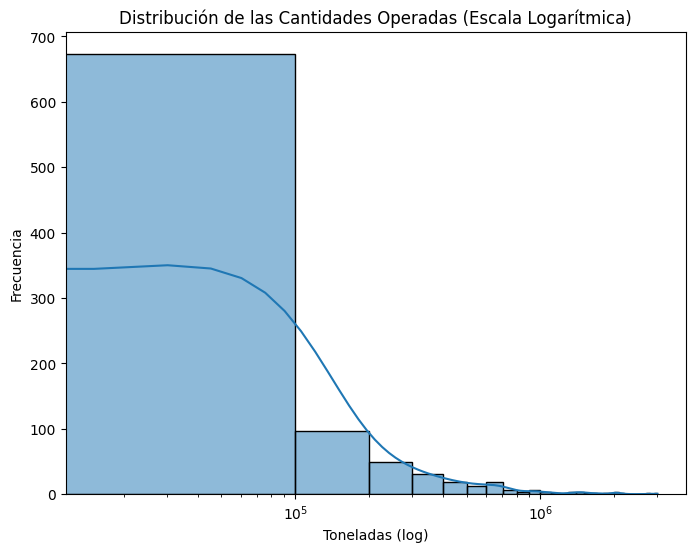

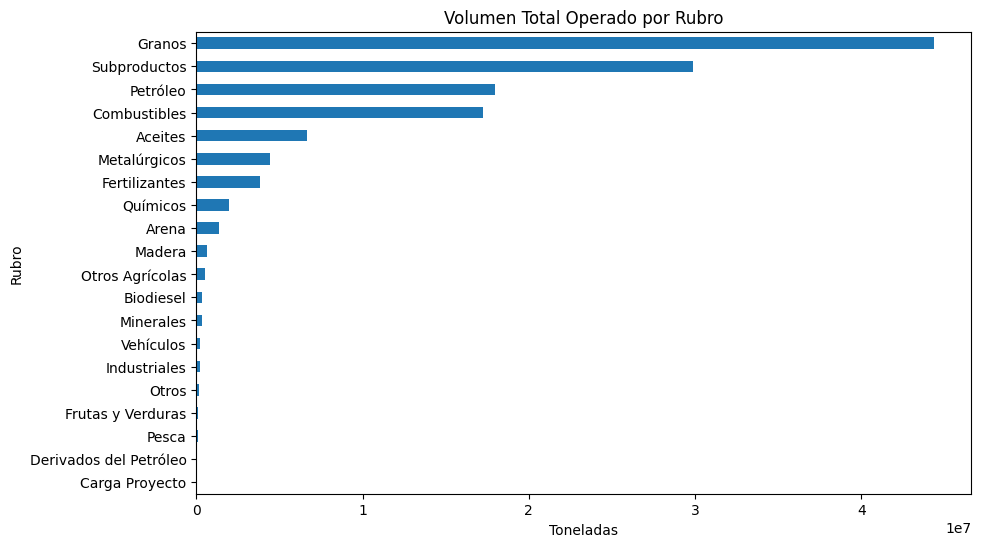

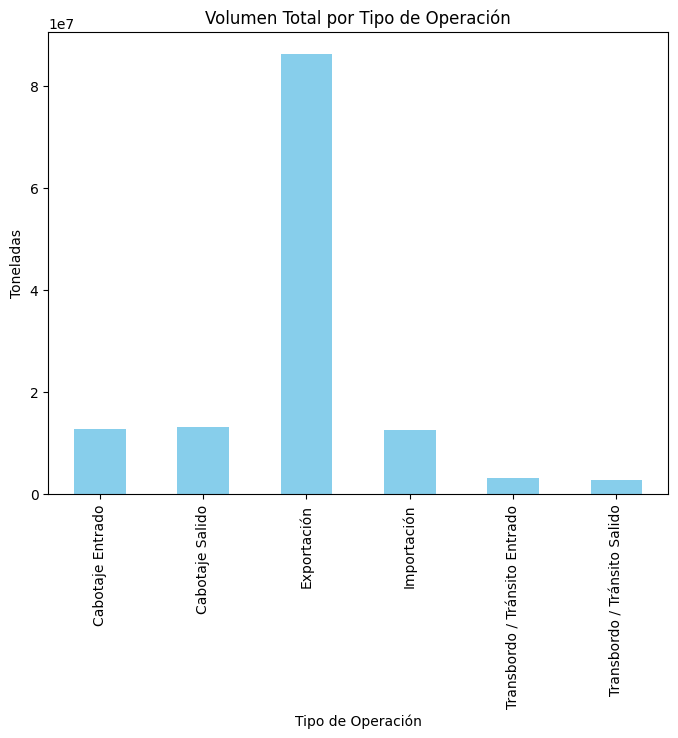

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer los datos (ajustá la ruta si hace falta)
df = pd.read_excel("carga_ncont_2024_6.xlsx")

# Resumen general
print("🔷 Resumen estadístico de las cantidades:")
print(df["Cantidades"].describe())

print("\n🔷 Valores únicos por columna:")
for col in ["Trimestre", "Provincia", "Puerto", "Rubro", "Tipo de Operación", "Unidad"]:
    print(f"{col}: {df[col].nunique()} categorías")

print("\n🔷 Puertos con mayor volumen operado:")
print(df.groupby("Puerto")["Cantidades"].sum().sort_values(ascending=False).head(5))

print("\n🔷 Rubros más frecuentes:")
print(df["Rubro"].value_counts().head(5))

print("\n🔷 Tipo de operación más comunes:")
print(df["Tipo de Operación"].value_counts())

# Gráfico 1: Distribución de las cantidades
plt.figure(figsize=(8,6))
sns.histplot(df["Cantidades"], bins=30, kde=True)
plt.xscale('log')
plt.title("Distribución de las Cantidades Operadas (Escala Logarítmica)")
plt.xlabel("Toneladas (log)")
plt.ylabel("Frecuencia")
plt.show()

# Gráfico 2: Volumen por Rubro
plt.figure(figsize=(10,6))
df.groupby("Rubro")["Cantidades"].sum().sort_values().plot(kind="barh")
plt.title("Volumen Total Operado por Rubro")
plt.xlabel("Toneladas")
plt.show()

# Gráfico 3: Volumen por Tipo de Operación
plt.figure(figsize=(8,6))
df.groupby("Tipo de Operación")["Cantidades"].sum().plot(kind="bar", color="skyblue")
plt.title("Volumen Total por Tipo de Operación")
plt.ylabel("Toneladas")
plt.show()

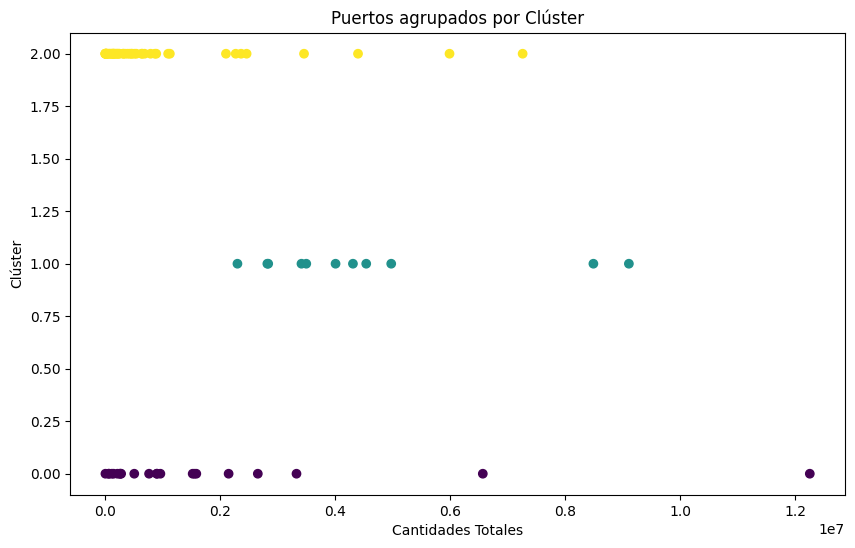

                               Cantidades  cluster
Puerto                                            
ACA (San Lorenzo)              1552942.65        0
ACA (Vilelas)                    20548.59        2
ADM AGRO (Arroyo Seco)         3327366.00        0
ADM AGRO - Muelle El Tránsito  2300256.91        1
Aceitera General Deheza        2146840.96        0

Cantidad de puertos por clúster:
 cluster
2    49
0    22
1    11
Name: count, dtype: int64


In [24]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = pd.read_excel("carga_ncont_2024_6.xlsx")

#  totales por puerto y provincia
df_grouped = df.groupby(['Puerto', 'Provincia']).agg({
    'Cantidades': 'sum'
}).reset_index()

#  proporciones de Rubro y Tipo de Operación
rubro_pivot = pd.pivot_table(df,
                             index='Puerto',
                             columns='Rubro',
                             values='Cantidades',
                             aggfunc='sum',
                             fill_value=0)

tipo_pivot = pd.pivot_table(df,
                            index='Puerto',
                            columns='Tipo de Operación',
                            values='Cantidades',
                            aggfunc='sum',
                            fill_value=0)

#  filas para tener proporciones
rubro_pivot = rubro_pivot.div(rubro_pivot.sum(axis=1), axis=0)
tipo_pivot = tipo_pivot.div(tipo_pivot.sum(axis=1), axis=0)


df_features = df_grouped.set_index('Puerto').join(rubro_pivot).join(tipo_pivot)


df_features = df_features.drop(columns=['Provincia'])


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Añadir columna de clúster
df_features['cluster'] = clusters

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.scatter(df_features['Cantidades'], df_features['cluster'],
            c=df_features['cluster'], cmap='viridis')
plt.xlabel('Cantidades Totales')
plt.ylabel('Clúster')
plt.title('Puertos agrupados por Clúster')
plt.show()


print(df_features[['Cantidades', 'cluster']].head())
print("\nCantidad de puertos por clúster:\n", df_features['cluster'].value_counts())

In [ ]:
import pandas as pd
import geopandas as gpd
import xml.etree.ElementTree as ET

# Definir el espacio de nombres
ns = {'kml': "http://www.opengis.net/kml/2.2"}

# Listas para almacenar los datos
nombres = []
longitudes = []
latitudes = []
caracteristicas = []

# Recorrer los elementos <Placemark> en el KML
for placemark in root.findall('.//kml:Placemark', ns):
    # Buscar el nombre en <SimpleData name="nombre">
    nombre_valor = None
    caracteristica_valor = None
    extended_data = placemark.find('.//kml:ExtendedData', ns)
    if extended_data is not None:
        for data in extended_data.findall('.//kml:SimpleData', ns):
            if data.attrib.get('name') == 'nombre':
                nombre_valor = data.text
            elif data.attrib.get('name') == 'caracteristica':
                caracteristica_valor = data.text

    nombres.append(nombre_valor)
    caracteristicas.append(caracteristica_valor)

    # Obtener las coordenadas
    point = placemark.find('.//kml:Point/kml:coordinates', ns)
    if point is not None and point.text:
        coords = point.text.strip().split(',')
        longitudes.append(float(coords[0]))
        latitudes.append(float(coords[1]))
    else:
        longitudes.append(None)
        latitudes.append(None)

# Crear un DataFrame con la información extraída
df = pd.DataFrame({
    'nombre': nombres,
    'longitud': longitudes,
    'latitud': latitudes,
    'caracteristica': caracteristicas
})

# Convertir a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitud'], df['latitud']), crs="EPSG:4326")

# Mostrar las primeras filas para verificar
print(gdf.head())



                         nombre   longitud    latitud caracteristica  \
0                       SIDERAR -60.158358 -33.358083        Privado   
1       PTO MARTINS - ASTILLERO -60.060278 -33.443722        Privado   
2                 BUNGE RAMALLO -60.038750 -33.453750        Privado   
3                      XSTORAGE -60.027361 -33.458083        Privado   
4  COOPERATIVA AGRICOLA RAMALLO -59.997878 -33.476036        Privado   

                      geometry  
0  POINT (-60.15836 -33.35808)  
1  POINT (-60.06028 -33.44372)  
2  POINT (-60.03875 -33.45375)  
3  POINT (-60.02736 -33.45808)  
4  POINT (-59.99788 -33.47604)  


In [ ]:
# Instalar librerías si no las tienes
!pip install geopandas folium scikit-learn

# Importar librerías
import geopandas as gpd
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
import pandas as pd

# Cargar el archivo KML
gdf = gpd.read_file("puertos.kml", driver='KML')

# Extraer latitud y longitud
gdf['longitud'] = gdf.geometry.x
gdf['latitud'] = gdf.geometry.y

# Leer el archivo KML para extraer nombres, provincia, localidad y característica
tree = ET.parse("puertos.kml")
root = tree.getroot()

# Namespace KML
ns = {'kml': 'http://www.opengis.net/kml/2.2'}

# Listas para almacenar la información adicional
nombres_puertos = []
provincias = []
localidades = []
caracteristicas = []

# Recorrer todos los <Placemark> en el archivo KML
for placemark in root.findall('.//kml:Placemark', ns):
    # Buscar dentro de <ExtendedData>
    extended_data = placemark.find('.//kml:ExtendedData', ns)
    nombre_valor = None
    provincia_valor = None
    localidad_valor = None
    caracteristica_valor = None

    if extended_data is not None:
        for data in extended_data.findall('.//kml:SimpleData', ns):
            if data.attrib.get('name') == 'nombre':
                nombre_valor = data.text
            elif data.attrib.get('name') == 'provincia':
                provincia_valor = data.text
            elif data.attrib.get('name') == 'localidad':
                localidad_valor = data.text
            elif data.attrib.get('name') == 'caracteristica':
                caracteristica_valor = data.text

    nombres_puertos.append(nombre_valor)
    provincias.append(provincia_valor)
    localidades.append(localidad_valor)
    caracteristicas.append(caracteristica_valor)

# Agregar los datos al GeoDataFrame
gdf['nombre'] = nombres_puertos
gdf['provincia'] = provincias
gdf['localidad'] = localidades
gdf['caracteristica'] = caracteristicas

# Eliminar filas sin coordenadas válidas
gdf = gdf.dropna(subset=['latitud', 'longitud'])

# Extraer las coordenadas para clustering
datos_clustering = gdf[['latitud', 'longitud']]

# Normalizar los datos
scaler = StandardScaler()
datos_normalizados = scaler.fit_transform(datos_clustering)

# Aplicar K-means para clustering
n_clusters = 3  # Número de clústeres
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
gdf['cluster'] = kmeans.fit_predict(datos_normalizados)

# Crear el mapa interactivo
mapa = folium.Map(location=[-34.6037, -58.3816], zoom_start=5)

# Definir colores por tipo de puerto
colores = {'Público': 'green', 'Privado': 'blue'}

# Agregar puntos al mapa
for _, row in gdf.iterrows():
    color = colores.get(row['caracteristica'], 'gray')  # Default a gris si no hay datos
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        popup=f"""
            <b>Nombre:</b> {row['nombre']}<br>
            <b>Provincia:</b> {row['provincia']}<br>
            <b>Localidad:</b> {row['localidad']}<br>
            <b>Tipo:</b> {row['caracteristica']}<br>
            <b>Cluster:</b> {row['cluster']}
        """
    ).add_to(mapa)

# Mostrar el mapa
mapa